In [3]:
import pandas as pd


In [20]:
andy = pd.read_csv('20231030_8210796956_MiFitness_hlth_center_fitness_data.csv')
tom = pd.read_csv('20231030_8211531339_MiFitness_hlth_center_fitness_data.csv')
huub = pd.read_csv('20231031_8210564343_MiFitness_hlth_center_fitness_data.csv')
oumaima = pd.read_csv('20231101_8210586841_MiFitness_hlth_center_fitness_data.csv')

In [21]:
andy['Person'] = 'andy'
tom['Person'] = 'tom'
huub['Person'] = 'huub'
oumaima['Person'] = 'oumaima'

master_frame = pd.concat([andy, tom, huub, oumaima], ignore_index=True)

In [31]:
unique_keys = ['pai',
               'valid_stand', 
               'calories',
               'steps',
               'heart_rate',
               'intensity',
               'dynamic',
               'single_heart_rate',
               'single_spo2',
               'training_load',
               'single_stress',
               'stress',
               'watch_night_sleep',
               'resting_heart_rate',
               #'watch_daytime_sleep',
               'weight']

# Create an empty dictionary to store the sub-dataframes
key_dataframes = {}

# Iterate through unique keys
for key in unique_keys:
    # Create a sub-dataframe for the current key
    key_df = master_frame[master_frame['Key'] == key].reset_index(drop=True)
    
    # Apply eval to 'Value' column and create 'Value_dict' column
    key_df['Value_dict'] = key_df['Value'].apply(eval)
    
    # Iterate through the keys in the 'Value_dict' column and add them as new columns
    for sub_key in key_df['Value_dict'][0].keys():
        key_df[sub_key] = key_df['Value_dict'].apply(lambda x: x.get(sub_key, None))
    
    # Drop the original 'Value_dict' column
    key_df = key_df.drop('Value_dict', axis=1)
    
    # Store the sub-dataframe in the dictionary
    key_dataframes[key] = key_df

# Now key_dataframes is a dictionary containing sub-dataframes for each unique value in the 'Key' column
# You can access each sub-dataframe using key_dataframes['heart_rate'], key_dataframes['steps'], etc.

# separate dataframes:
pai_df = key_dataframes['pai']
valid_stand_df = key_dataframes['valid_stand']
calories_df = key_dataframes['calories']
steps_df = key_dataframes['steps']
heart_rate_df = key_dataframes['heart_rate']
intensity_df = key_dataframes['intensity']
dynamic_df = key_dataframes['dynamic']
single_heart_rate_df = key_dataframes['single_heart_rate']
single_spo2_df = key_dataframes['single_spo2']
training_load_df = key_dataframes['training_load']
single_stress_df = key_dataframes['single_stress']
stress_df = key_dataframes['stress']
watch_night_sleep_df = key_dataframes['watch_night_sleep']
resting_heart_rate_df = key_dataframes['resting_heart_rate']
#watch_daytime_sleep_df = key_dataframes['watch_daytime_sleep']
weight_df = key_dataframes['weight']

NameError: name 'true' is not defined

In [34]:
master_frame[master_frame['Key'] == 'watch_daytime_sleep']['Value'].iloc[0]

'{"awake_count":0,"sleep_rem_duration":0,"sleep_deep_duration":0,"breath_quality":74,"wake_up_time":1696110540,"items":[{"state":3,"start_time":1696108380,"end_time":1696110540,"ended":true}],"sleep_awake_duration":0,"timezone":8,"duration":36,"bedtime":1696108380,"date_time":1696032000,"sleep_light_duration":36}'

In [29]:
watch_night_sleep_df

,Uid,Sid,Key,Time,Value,UpdateTime,Person,sleep_deep_duration,items,wake_up_time,sleep_rem_duration,timezone,duration,sleep_awake_duration,bedtime,date_time,sleep_light_duration,awake_count
0,8210796956,huami.39873/AAAAC13TA75455,watch_night_sleep,1694649600,"{""sleep_deep_duration"":71,""items"":[{""start_tim...",1695116316,andy,71,"[{'start_time': 1694644980, 'state': 3, 'end_t...",1694668560,85,8,393,0,1694644980,1694649600,237,0
1,8210796956,huami.39873/AAAAC13TA75455,watch_night_sleep,1694736000,"{""awake_count"":0,""sleep_rem_duration"":48,""slee...",1695116316,andy,78,"[{'start_time': 1694729640, 'state': 3, 'end_t...",1694756520,48,8,448,0,1694729640,1694736000,322,0
2,8210796956,huami.39873/AAAAC13TA75455,watch_night_sleep,1694822400,"{""awake_count"":1,""sleep_rem_duration"":73,""slee...",1695116316,andy,76,"[{'start_time': 1694821560, 'state': 3, 'end_t...",1694850420,73,8,472,9,1694821560,1694822400,323,1
3,8210796956,huami.39873/AAAAC13TA75455,watch_night_sleep,1694908800,"{""awake_count"":0,""sleep_rem_duration"":90,""slee...",1695116316,andy,69,"[{'start_time': 1694906760, 'state': 3, 'end_t...",1694929800,90,8,384,0,1694906760,1694908800,225,0
4,8210796956,huami.39873/AAAAC13TA75455,watch_night_sleep,1694995200,"{""awake_count"":0,""sleep_rem_duration"":102,""sle...",1695116316,andy,34,"[{'start_time': 1694991660, 'state': 3, 'end_t...",1695015180,102,8,392,0,1694991660,1694995200,256,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,8210586841,huami.39873/AAAAC13SP84484,watch_night_sleep,1697241600,"{""sleep_deep_duration"":61,""items"":[{""start_tim...",1697451954,oumaima,61,"[{'start_time': 1697228340, 'state': 3, 'end_t...",1697258580,118,8,489,15,1697228340,1697241600,310,1
165,8210586841,huami.39873/AAAAC13SP84484,watch_night_sleep,1697328000,"{""sleep_deep_duration"":53,""items"":[{""start_tim...",1697451954,oumaima,53,"[{'start_time': 1697317260, 'state': 3, 'end_t...",1697346840,79,8,492,1,1697317260,1697328000,360,1
166,8210586841,huami.39873/AAAAC13SP84484,watch_night_sleep,1697414400,"{""sleep_deep_duration"":42,""items"":[{""start_tim...",1697526375,oumaima,42,"[{'start_time': 1697404140, 'state': 3, 'end_t...",1697433900,97,8,496,0,1697404140,1697414400,357,0
167,8210586841,huami.39873/AAAAC13SP84484,watch_night_sleep,1697500800,"{""sleep_deep_duration"":78,""items"":[{""start_tim...",1697605019,oumaima,78,"[{'start_time': 1697487720, 'state': 3, 'end_t...",1697519160,110,8,524,0,1697487720,1697500800,336,0


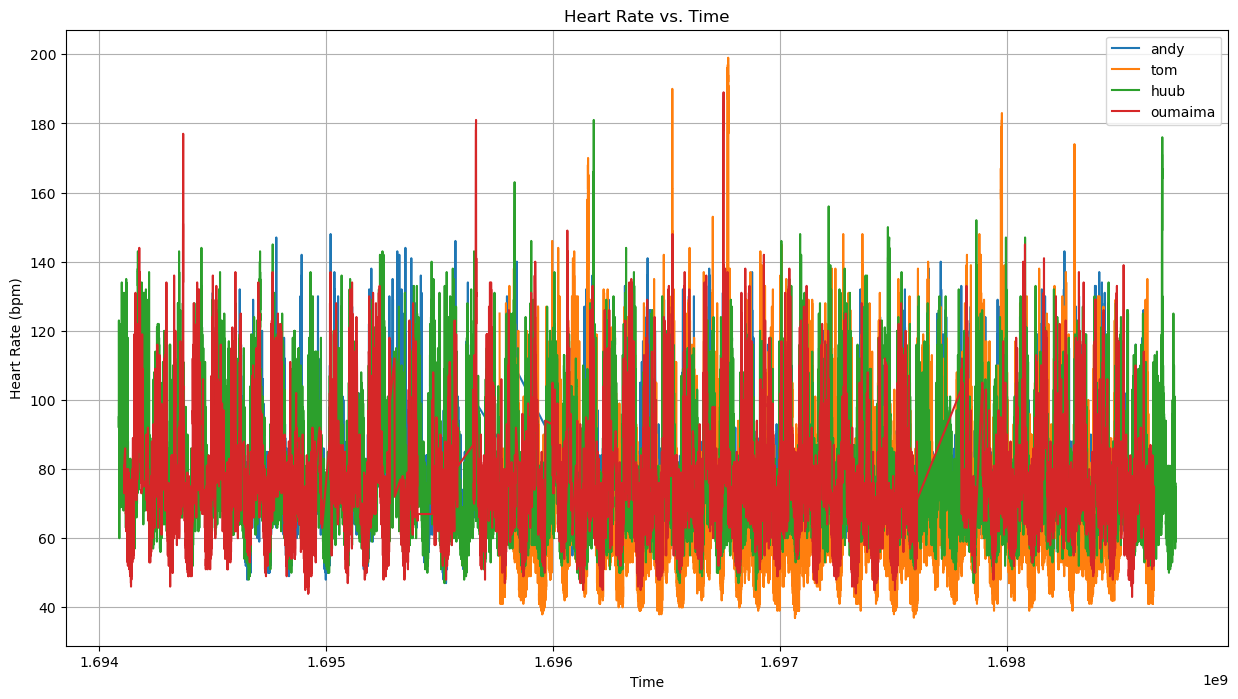

In [23]:
# Plot for all of us together
persons = heart_rate_df['Person'].unique()

plt.figure(figsize=(15, 8))

for person in persons:
    person_data = heart_rate_df[heart_rate_df['Person'] == person]
    plt.plot(person_data['Time'], person_data['bpm'], label=person)

plt.title('Heart Rate vs. Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True)
plt.show()


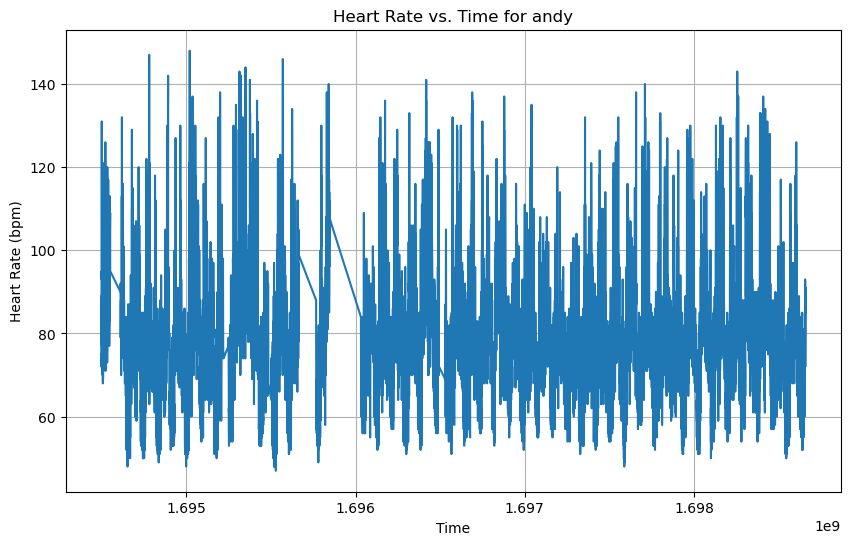

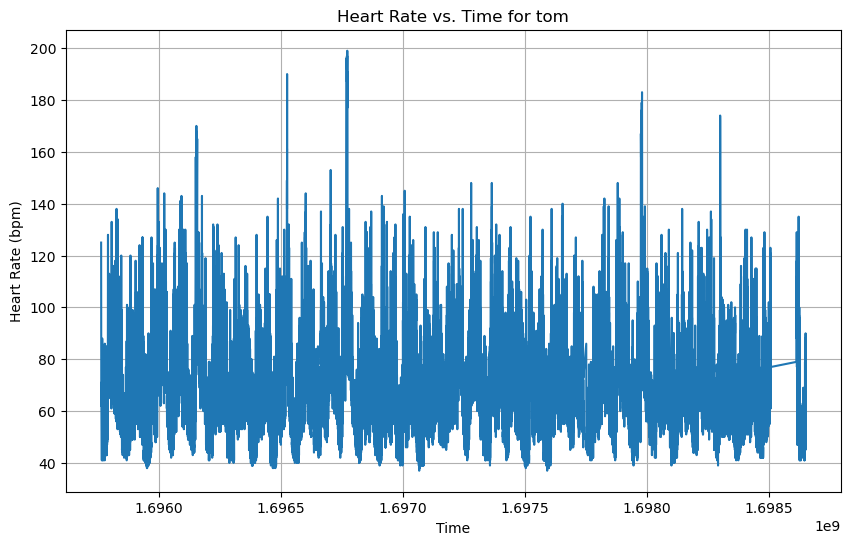

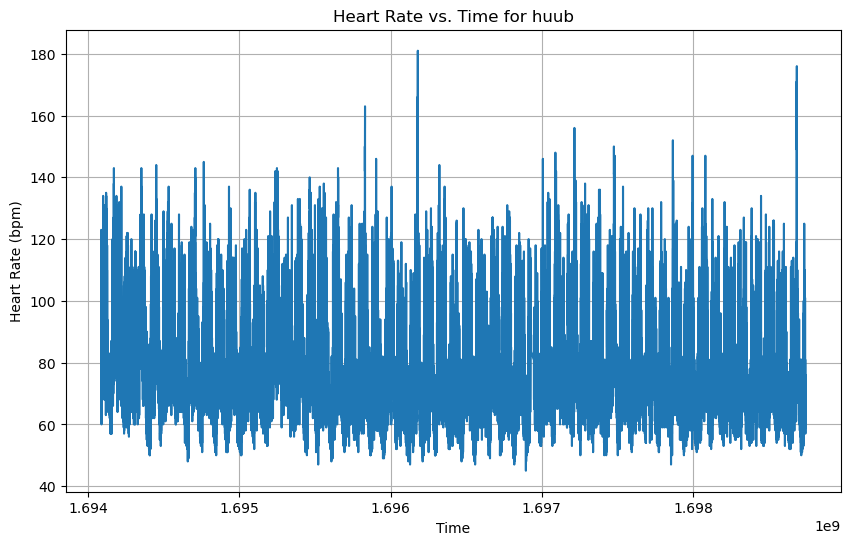

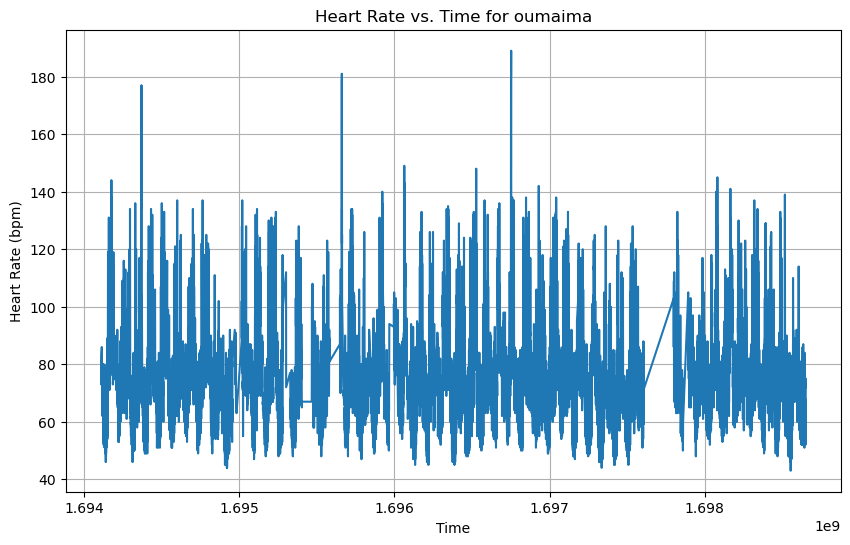

In [24]:
# Plot for each person separately
for person in persons:
    person_data = heart_rate_df[heart_rate_df['Person'] == person]
    
    plt.figure(figsize=(10, 6))
    plt.plot(person_data['Time'], person_data['bpm'])
    
    plt.title(f'Heart Rate vs. Time for {person}')
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True)
    
    plt.show()

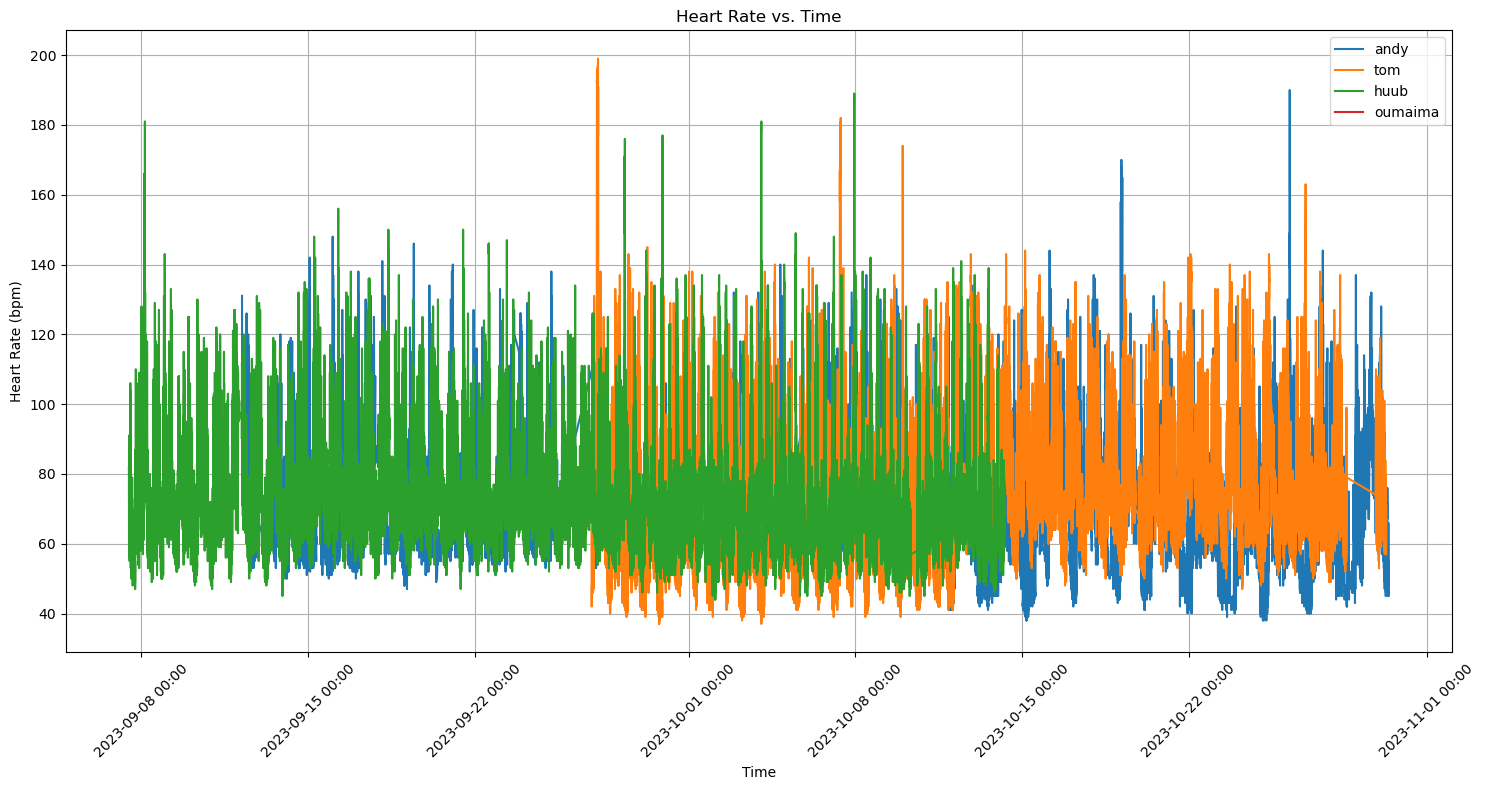

In [9]:
heart_rate_df['DateTime'] = pd.to_datetime(heart_rate_df['Time'], unit='s')
import matplotlib.dates as mdates

plt.figure(figsize=(15, 8))

# For each person, plot their data
for person in persons:
    person_data = heart_rate_df[heart_rate_df['Person'] == person]
    plt.plot(person_data['DateTime'], person_data['bpm'], label=person)

# Formatting the x-axis
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Heart Rate vs. Time')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.tight_layout()  # To ensure labels fit
plt.legend()
plt.grid(True)
plt.show()


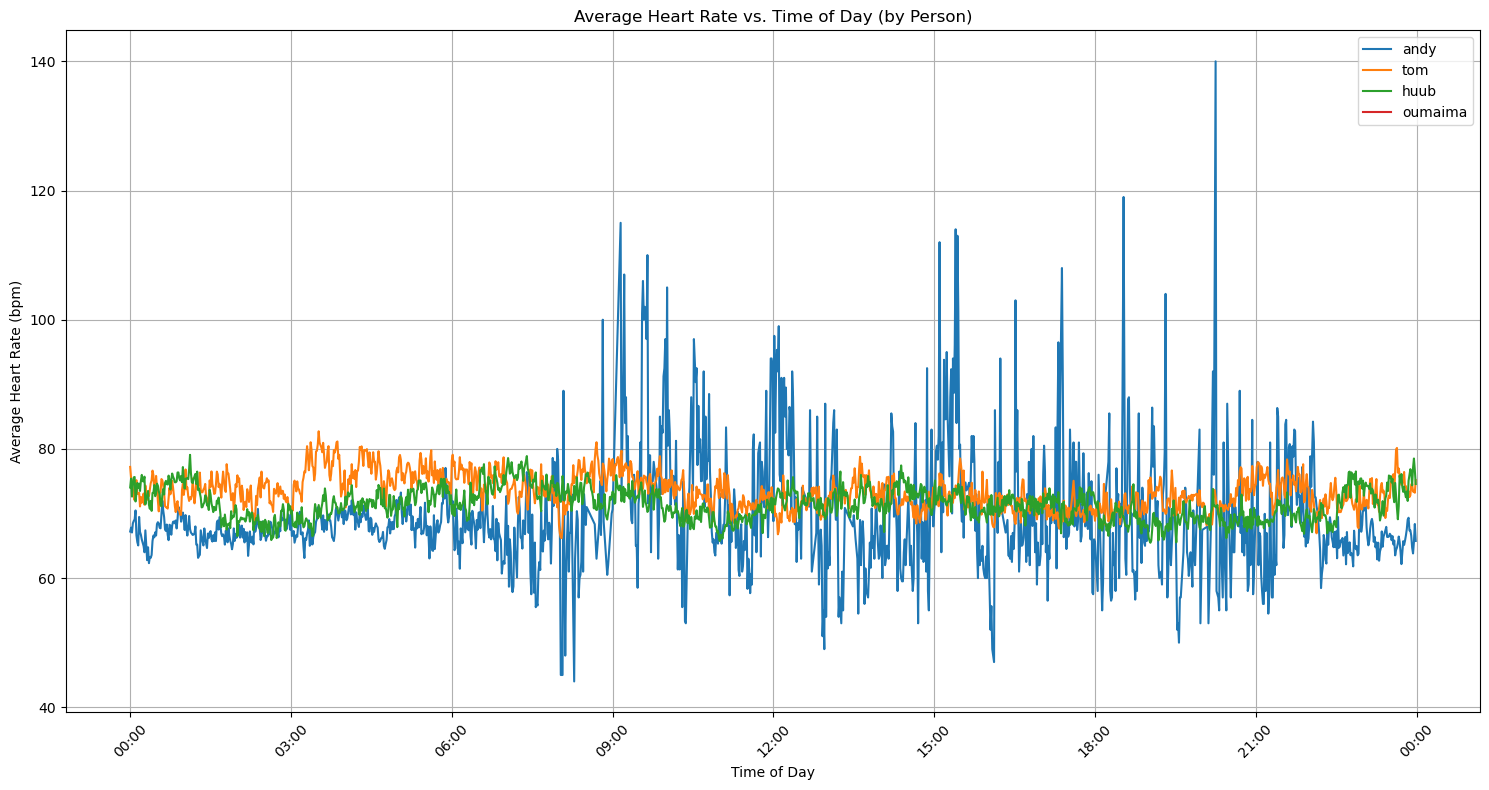

In [10]:
heart_rate_df['Hour'] = heart_rate_df['DateTime'].dt.hour
heart_rate_df['Minute'] = heart_rate_df['DateTime'].dt.minute
avg_heart_rate_per_person = heart_rate_df.groupby(['Person', 'Hour', 'Minute'])['bpm'].mean().reset_index()

avg_heart_rate_per_person['TimeOfDay'] = pd.to_datetime('2000-01-01 ' + avg_heart_rate_per_person['Hour'].astype(str) + ':' + avg_heart_rate_per_person['Minute'].astype(str))

plt.figure(figsize=(15, 8))

# For each person, plot their average heart rate
for person in persons:
    person_data = avg_heart_rate_per_person[avg_heart_rate_per_person['Person'] == person]
    plt.plot(person_data['TimeOfDay'], person_data['bpm'], label=person)

# Formatting the x-axis
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

plt.title('Average Heart Rate vs. Time of Day (by Person)')
plt.xlabel('Time of Day')
plt.ylabel('Average Heart Rate (bpm)')
plt.tight_layout()  # To ensure labels fit
plt.legend()
plt.grid(True)
plt.show()


# Intuition

I think we need to include control variables such as the number of hours sleep and the quality of sleep as this significantly influences your mental state after awaking.

I guess we can check whether someone has slept after their alarm right?

We must include variable for smart alarm or not. Can we find this in the settings from the mi band?